In [1]:

# ✅ Imports
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [2]:

def build_efficientnet_binary_model(input_shape=(128, 128, 3), version="B0"):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model, base_model


In [3]:

def prepare_binary_data(data_dir, target_size=(128, 128), batch_size=32, val_split=0.2):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)
    train_gen = datagen.flow_from_directory(data_dir, target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            subset='training')
    val_gen = datagen.flow_from_directory(data_dir, target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='validation')
    return train_gen, val_gen


In [4]:

def train_binary_model(model, train_gen, val_gen, version="B0", category="binary", epochs=5):
    os.makedirs(f"models/{category}", exist_ok=True)
    save_path = f"models/{category}/efficientnet_{version}.keras"

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=f"logs/efficientnet_{version}")
    ]

    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=epochs,
                        callbacks=callbacks)
    return history


In [5]:

def fine_tune_binary_model(model, base_model, train_gen, val_gen, fine_tune_at=100,
                           initial_epochs=5, fine_tune_epochs=5, version="B0", category="binary"):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    total_epochs = initial_epochs + fine_tune_epochs
    save_path = f"models/{category}/efficientnet_{version}_finetuned.keras"
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=f"logs/efficientnet_{version}_finetune")
    ]

    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=total_epochs,
                        initial_epoch=initial_epochs,
                        callbacks=callbacks)
    return history


In [6]:

def evaluate_binary_model_with_confusion(model, val_gen, class_names=None, normalize=True):
    loss, acc = model.evaluate(val_gen, verbose=0)
    print(f"✅ Accuracy: {acc*100:.2f}%, Loss: {loss:.4f}")

    y_true = val_gen.classes
    y_pred_probs = model.predict(val_gen, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

    if class_names is None:
        class_names = list(val_gen.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.gcf().set_size_inches(8, 6)
    plt.title("📌 Matrice de confusion")
    plt.tight_layout()
    plt.show()


In [9]:

def continue_binary_training_from_checkpoint(model_path, train_gen, val_gen, version="B0", category="binary",
                                             additional_epochs=5, fine_tune_at=100, learning_rate=1e-5):
    model = tf.keras.models.load_model(model_path)
    print(f"✅ Loaded model from {model_path}")

    base_model = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            break

    if base_model:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        print(f"🔁 Fine-tuning enabled from layer {fine_tune_at}")
    else:
        print("⚠️ No base model found for fine-tuning.")

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    save_path = f"models/{category}/efficientnet_{version}_continued.keras"
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=f"logs/efficientnet_{version}_continued")
    ]

    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=additional_epochs,
                        callbacks=callbacks)

    return model, history


Found 18618 images belonging to 2 classes.
Found 4653 images belonging to 2 classes.
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - accuracy: 0.5558 - loss: 0.6944 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 315s 448ms/step - accuracy: 0.5670 - loss: 0.6850 - val_accuracy: 0.5706 - val_loss: 0.6830
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 300s 516ms/step - accuracy: 0.5686 - loss: 0.6853 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 538s 924ms/step - accuracy: 0.5664 - loss: 0.6844 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 460s 790ms/step - accuracy: 0.5698 - loss: 0.6839 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 6/35
582/582 ━━━━━━━━━━━━━━━━━━━━ 647s 985ms/step - accuracy: 0.5883 - loss: 0.7597 - val_accuracy: 0.6669 - val_loss: 0.5900
Epoch 7/35
582/582 ━━━━━━━━━━━━━━━━━━━━ 362s 620ms/step - accuracy: 0.7350 - loss: 0.5033 - val_accuracy: 0.6937 - val_loss: 0.5624

C:\Users\loren\AppData\Local\Temp\ipykernel_23472\2361859782.py:20: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\loren\Documents\GitHub\TouNum\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


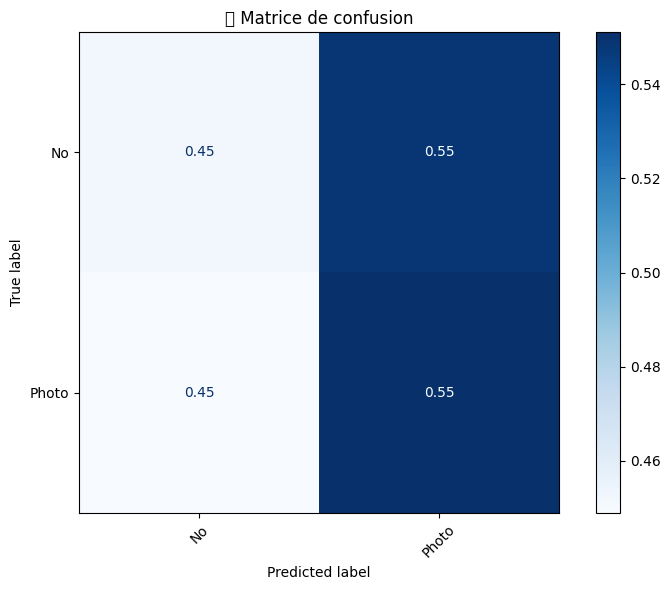

In [11]:

# 🔁 Example usage for binary classification
data_dir = './dataset_binary'
train_gen, val_gen = prepare_binary_data(data_dir)
model, base_model = build_efficientnet_binary_model(version="B0")
history = train_binary_model(model, train_gen, val_gen, version="B0")
history_ft = fine_tune_binary_model(model, base_model, train_gen, val_gen, initial_epochs=len(history.epoch),fine_tune_epochs=30, version="B0")
evaluate_binary_model_with_confusion(model, val_gen)
